<a href="https://colab.research.google.com/github/ngabo-dev/sentiment-analysis_group3/blob/main/diana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Amazon Reviews Sentiment Analysis: SVM vs 1D CNN
# -------------------------------------------------
# Works directly from processed_dataset.csv
# TF-IDF features for SVM, padded sequences + embeddings for CNN

# -----------------------------
# 1️⃣ Imports
# -----------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
# -----------------------------
# 2️⃣ Load Data
# -----------------------------
df = pd.read_csv("processed_dataset.csv")
print("Dataset loaded:", df.shape)
df.head()

Dataset loaded: (71204, 3)


,text,proc,label
0,This is by far my favorite K cup. It is a stro...,far favorite cup strong flavorful harsh coffee...,1
1,"OK, I am now READDICTED to SUGAR! This stuff ...",readdicted sugar stuff much much better silk c...,1
2,I don't understand how anyone with a pair of t...,understand anyone pair taste bud rub together ...,0
3,a favorite.....Tetley tea's British decaffeina...,favorite tetley tea british decaffeinated blen...,1
4,Something about the flavor just isn't right. ...,something flavor right purchased consumed lot ...,0


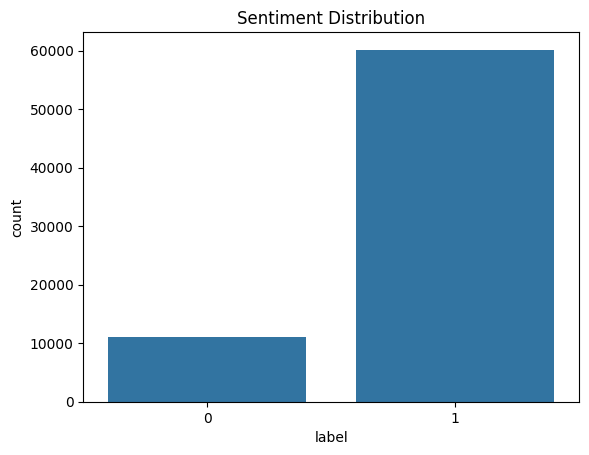

In [6]:
# -----------------------------
# 3️⃣ EDA
# -----------------------------
# Distribution of labels
sns.countplot(x='label', data=df)
plt.title("Sentiment Distribution")
plt.show()

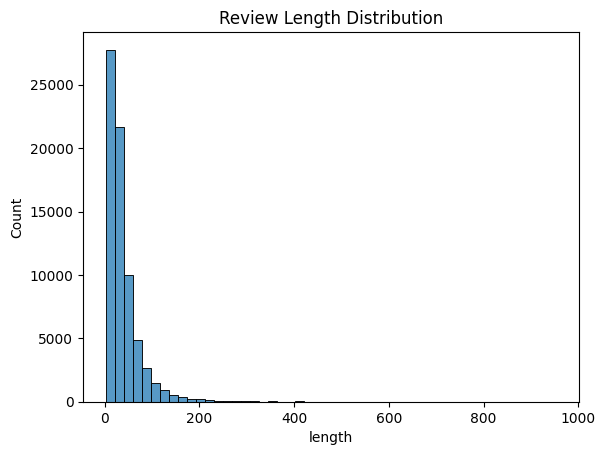

In [7]:
# Review length distribution
df['length'] = df['proc'].apply(lambda x: len(x.split()))
sns.histplot(df['length'], bins=50)
plt.title("Review Length Distribution")
plt.show()

In [8]:
# -----------------------------
# 4️⃣ Split Data
# -----------------------------
X = df['proc'].values
y = df['label'].values

# Stratified split: train/val/test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1, stratify=y_temp, random_state=42)

print("Train/Val/Test sizes:", len(X_train), len(X_val), len(X_test))

Train/Val/Test sizes: 51266 5697 14241


In [10]:
# -----------------------------
# 5️⃣ TF-IDF Features (for SVM)
# -----------------------------
tfidf_vect = TfidfVectorizer(max_features=30000, ngram_range=(1,2), min_df=2, max_df=0.98)
X_train_tfidf = tfidf_vect.fit_transform(X_train)
X_val_tfidf   = tfidf_vect.transform(X_val)
X_test_tfidf  = tfidf_vect.transform(X_test)

print("TF-IDF shapes:", X_train_tfidf.shape, X_val_tfidf.shape, X_test_tfidf.shape)

TF-IDF shapes: (51266, 30000) (5697, 30000) (14241, 30000)



SVM Experiment Results:
   kernel    C  val_accuracy
0  linear  1.0      0.929963
1  linear  0.5      0.925575
2     rbf  1.0      0.928208
3     rbf  0.5      0.912410

SVM Test Accuracy: 0.9324485640053367

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.67      0.76      2209
           1       0.94      0.98      0.96     12032

    accuracy                           0.93     14241
   macro avg       0.90      0.83      0.86     14241
weighted avg       0.93      0.93      0.93     14241



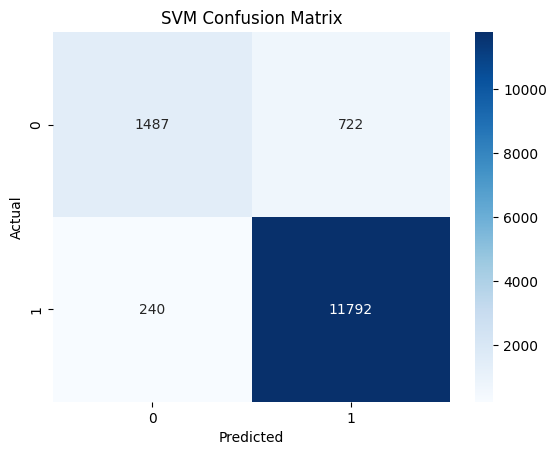

In [11]:
# -----------------------------
# 6️⃣ Traditional ML: SVM
# -----------------------------
# Experiment table: different kernels & C
svm_experiments = [
    {'kernel': 'linear', 'C': 1.0},
    {'kernel': 'linear', 'C': 0.5},
    {'kernel': 'rbf',    'C': 1.0},
    {'kernel': 'rbf',    'C': 0.5},
]

svm_results = []
for exp in svm_experiments:
    svm = SVC(kernel=exp['kernel'], C=exp['C'], random_state=42)
    svm.fit(X_train_tfidf, y_train)
    y_val_pred = svm.predict(X_val_tfidf)
    acc = accuracy_score(y_val, y_val_pred)
    svm_results.append({'kernel': exp['kernel'], 'C': exp['C'], 'val_accuracy': acc})

df_svm_results = pd.DataFrame(svm_results)
print("\nSVM Experiment Results:")
print(df_svm_results)

# Best SVM on test set
best_svm = SVC(kernel='linear', C=1.0, random_state=42)
best_svm.fit(X_train_tfidf, y_train)
y_test_pred_svm = best_svm.predict(X_test_tfidf)
print("\nSVM Test Accuracy:", accuracy_score(y_test, y_test_pred_svm))
print("\nSVM Classification Report:\n", classification_report(y_test, y_test_pred_svm))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred_svm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()